In [10]:
%load_ext autoreload
%autoreload 2

import sys

sys.path.append("../")


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
NUM_SAMPLES: int = 100
NOISE: float = 5.0
BIAS: float = 1.23
STATE: int = 2023
IN_FEATURES: int = 1
OUT_FEATURES: int = 1
TEMPLATE = "ggplot2"


In [12]:
import torch
from sklearn.datasets import make_regression
import plotly.express as px
import plotly.graph_objects as go
import pandas as pd
from tqdm.notebook import tqdm


PALETTE = px.colors.qualitative.Plotly
figKwargs = dict(
    width=700,
    height=400,
    color_discrete_sequence=PALETTE,
)
showKwargs = dict(
    renderer="png", scale=2
)  # change renderer to "" to use interactive plots


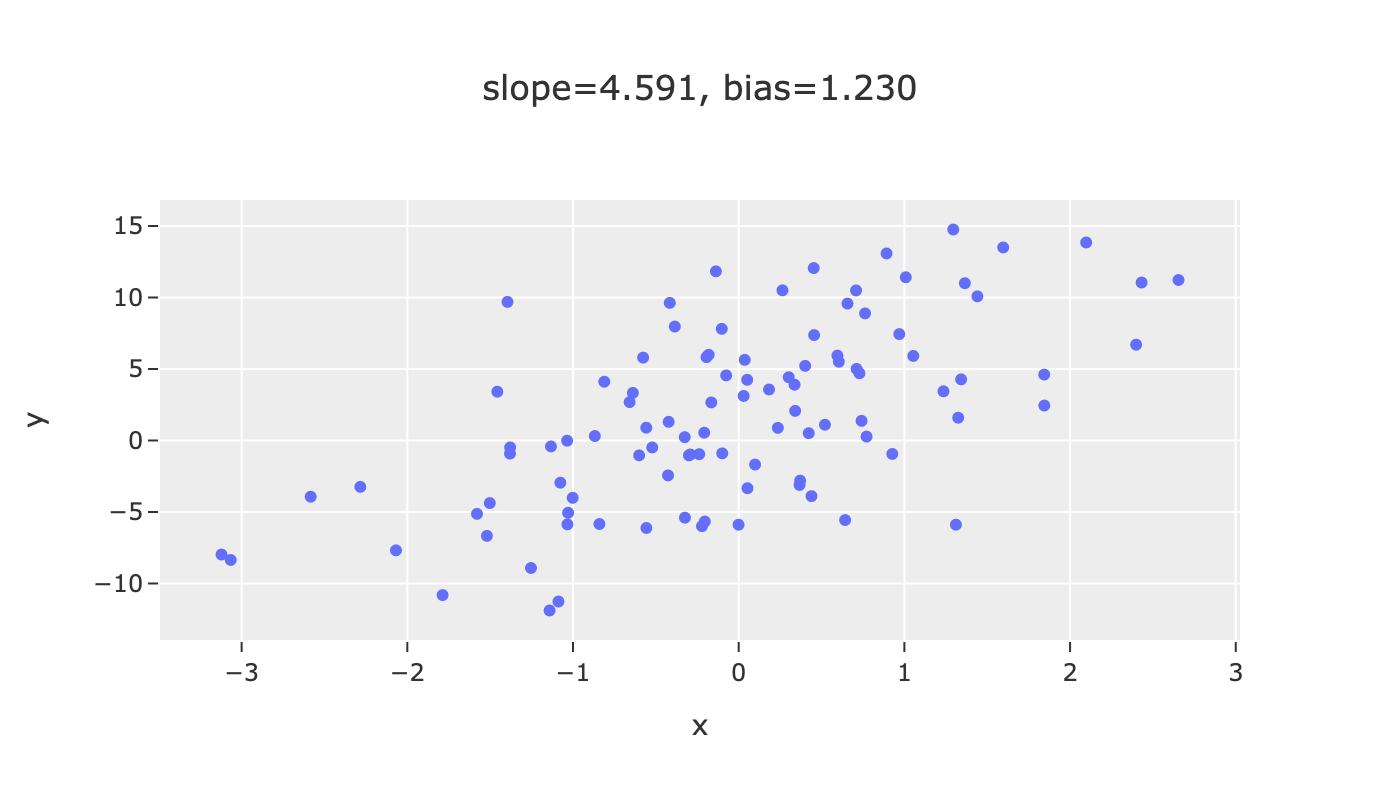

In [13]:
X, y, coef = make_regression(
    n_samples=NUM_SAMPLES,
    n_targets=OUT_FEATURES,
    n_features=IN_FEATURES,
    n_informative=IN_FEATURES,
    noise=NOISE,
    bias=BIAS,
    random_state=STATE,
    coef=True,
)
# X = (X - X.mean(0, keepdims=True)) / X.std(0, keepdims=True)
X = torch.from_numpy(X).to(torch.float32)
y = torch.from_numpy(y).to(torch.float32)
if y.ndim == 1:
    y = y[..., None]
if IN_FEATURES == OUT_FEATURES == 1:
    fig = px.scatter(
        x=X.squeeze(),
        y=y.squeeze(),
        template=TEMPLATE,
        title=f"slope={coef:.3f}, bias={BIAS:.3f}",
        **figKwargs
    )
    fig.show(**showKwargs)


In [14]:
from ml.losses import MAELoss, MSELoss
from ml.models.linear import Linear
from ml.optim import SGD

LR = 0.01
N = 40000

# Linear model init
criterion = MAELoss()
model = Linear(IN_FEATURES, OUT_FEATURES, criterion)
optim = SGD(model.parameters(), model.grad(), LR)

# PyTorch init
t_model = torch.nn.Linear(IN_FEATURES, OUT_FEATURES)
# Start with same parameters
t_model.weight = torch.nn.Parameter(model.weight.clone())
t_model.bias = torch.nn.Parameter(model.bias.clone())
t_criterion = torch.nn.L1Loss()


In [15]:
model.fit(X, y, optim, n_epochs=N, verbose=True)

  0%|          | 0/40000 [00:00<?, ?it/s]

In [8]:
history = []
for _ in tqdm(range(N)):
    for p in t_model.parameters():
        p.grad = None
    outptut = t_model(X)
    loss = t_criterion(outptut, y)
    loss.backward()
    for p in t_model.parameters():
        p.data -= p.grad * LR
    history.append(loss.item())

  0%|          | 0/40000 [00:00<?, ?it/s]

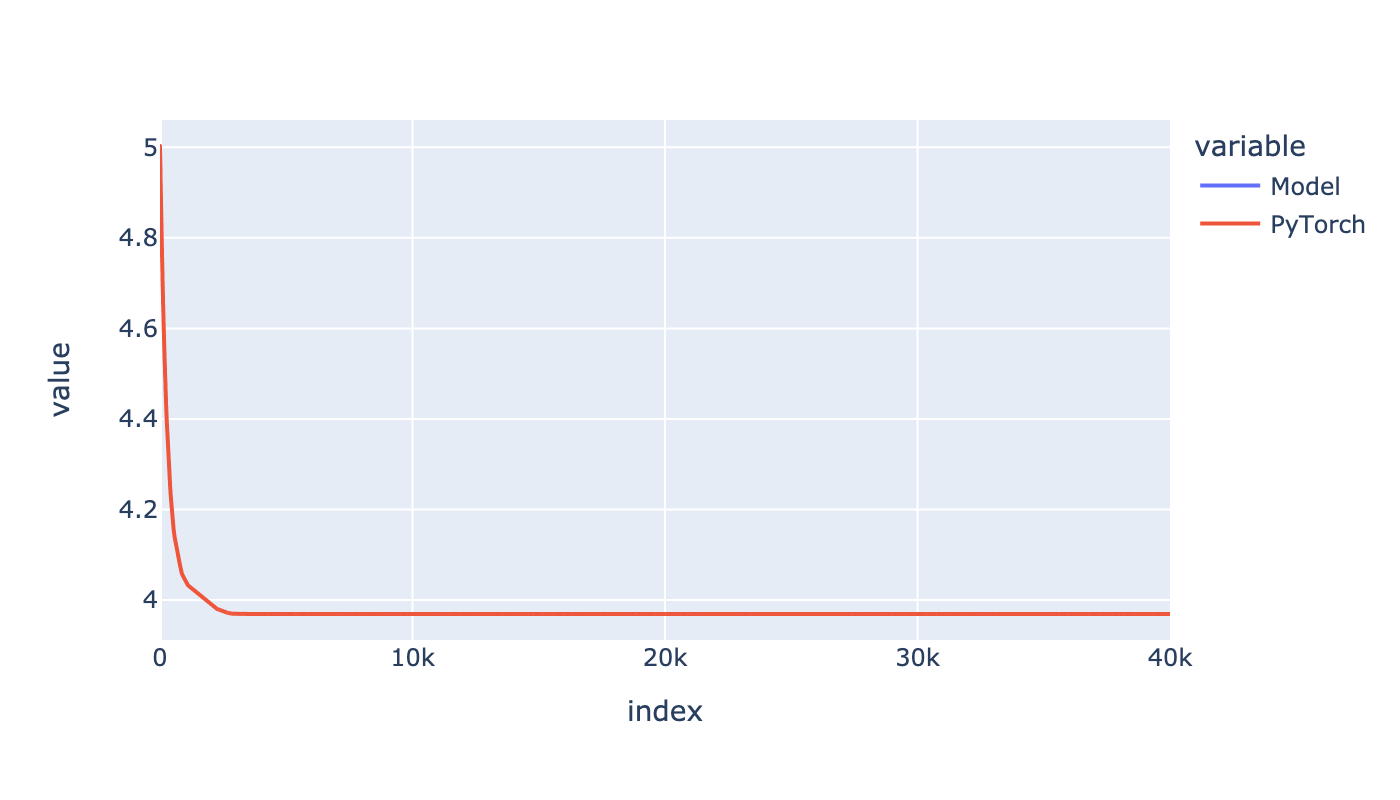

In [9]:
data = pd.DataFrame(dict(Model=model.history, PyTorch=history))
fig = px.line(data, **figKwargs)
fig.show(**showKwargs)

In [10]:
# check that weights and biases are close

assert torch.allclose(t_model.weight.data, model.weight.data)
assert torch.allclose(t_model.bias.data, model.bias.data)

In [11]:
t_model.weight.data, model.weight

(tensor([[3.4640]]), tensor([[3.4640]]))

In [27]:
from ml.metrics.functional import r2_score, mse
output = model(X)
r2_score(output, y, "mean")

tensor(0.3845)

In [28]:
data = torch.randn(100, 2), torch.randn(100, 2)
r2_score(*data)

tensor(-1.0871)

In [29]:
from sklearn.metrics import r2_score, mean_absolute_error,mean_squared_error
torch.tensor(mean_absolute_error(data[1], data[0]))

tensor(1.1676)

In [31]:
data = torch.randn(100, 2), torch.randn(100, 2)
comparisons = [
    ["mse", "mean_squared_error"],
    ["mae", "mean_absolute_error"],
    ["r2_score", "r2_score"],
]
# for comparison in comparison:

a = mse(*data, reduction="mean")
b = torch.tensor(
    mean_squared_error(data[1], data[0])
)

In [32]:
a, b

(tensor(1.7773), tensor(1.7773))

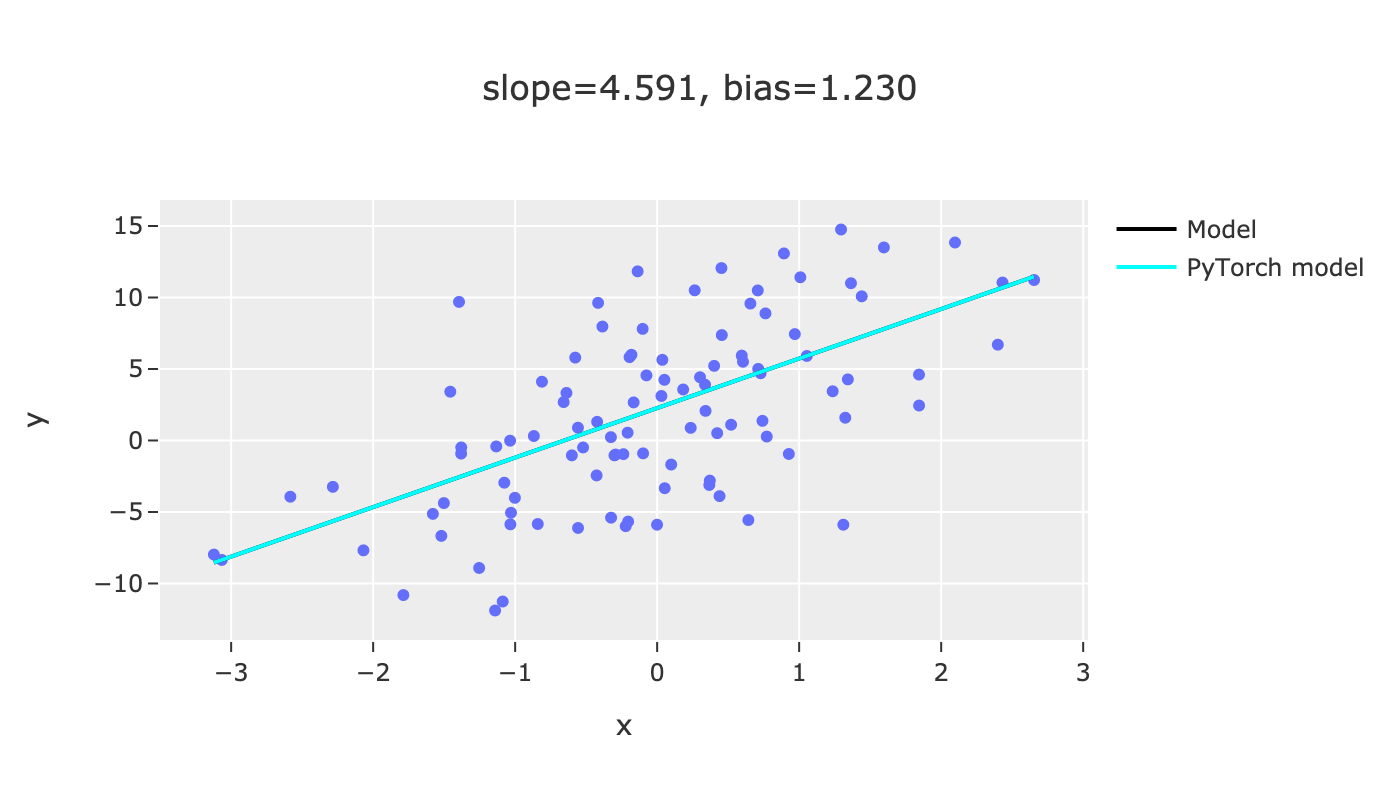

In [63]:
output = model.predict(X)
with torch.no_grad():
    t_output = t_model(X)

fig = px.scatter(
    x=X.squeeze(),
    y=y.squeeze(),
    template=TEMPLATE,
    title=f"slope={coef:.3f}, bias={BIAS:.3f}",
    **figKwargs
)
fig.add_trace(
    go.Scatter(
        x=X.squeeze(), y=output.squeeze(), name="Model", marker=dict(color="black")
    )
)
fig.add_trace(
    go.Scatter(
        x=X.squeeze(), y=t_output.squeeze(), name="PyTorch model", marker=dict(color="cyan")
    )
)
fig.show(**showKwargs)
